<a href="https://colab.research.google.com/github/G0rav/Image_Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/images/segmentation

https://keras.io/examples/vision/oxford_pets_image_segmentation/

https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

In [2]:
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt
% matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'

In [3]:
pet, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2K2WDL/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2K2WDL/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
type(pet['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [6]:
images = list(pet['train'].map(lambda x: x['image']))
display(len(images))
display(images[0].shape, images[1].shape)

3680

TensorShape([500, 500, 3])

TensorShape([313, 500, 3])

In [7]:
segmentation_masks = list(pet['train'].map(lambda x: x['segmentation_mask']))
display(len(segmentation_masks))
display(segmentation_masks[0].shape, segmentation_masks[1].shape)

3680

TensorShape([500, 500, 1])

TensorShape([313, 500, 1])

In [8]:
labels = list(pet['train'].map(lambda x: x['label']))
display(len(labels))
display(labels[0], labels[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=33>

<tf.Tensor: shape=(), dtype=int64, numpy=12>

In [9]:
dir(labels[0])

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',


In [10]:
species = list(pet['train'].map(lambda x: x['species']))
display(len(species))
display(species[0], species[1])

3680

<tf.Tensor: shape=(), dtype=int64, numpy=0>

<tf.Tensor: shape=(), dtype=int64, numpy=1>

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(33, shape=(), dtype=int64)


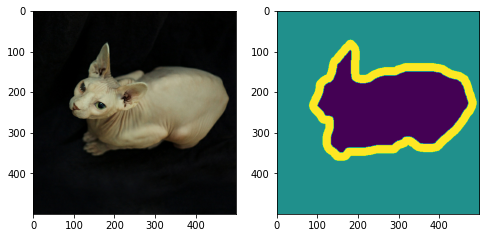

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(34, shape=(), dtype=int64)


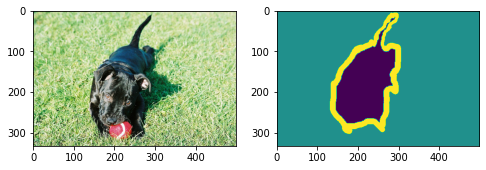

species: tf.Tensor(0, shape=(), dtype=int64)
label: tf.Tensor(5, shape=(), dtype=int64)


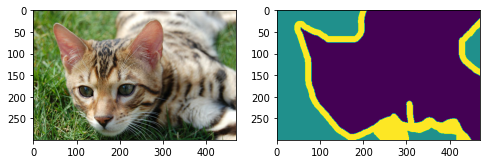

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(31, shape=(), dtype=int64)


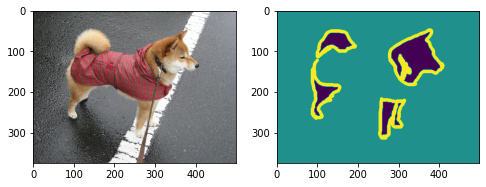

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(30, shape=(), dtype=int64)


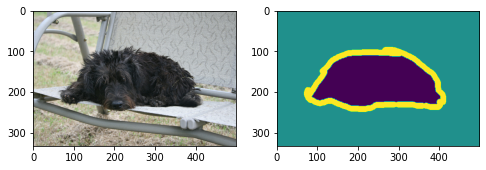

species: tf.Tensor(1, shape=(), dtype=int64)
label: tf.Tensor(10, shape=(), dtype=int64)


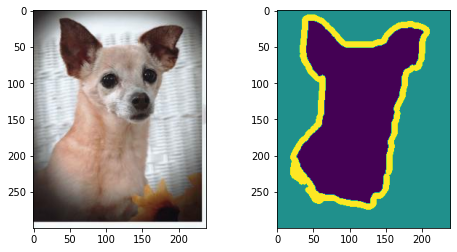

In [11]:
for i in [0,100,500,1000,2000,3000]:
  print(f'species:',species[i])
  print(f'label:',labels[i])

  plt.figure(figsize = (8,4))
  plt.subplot(121)
  image = np.array(images[i])
  plt.imshow(image)

  plt.subplot(122)
  mask = np.array(segmentation_masks[i])
  mask = mask.reshape(mask.shape[0], mask.shape[1])
  plt.imshow(mask)
  plt.show()


## Create Dataset

In [12]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [13]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [14]:
train = pet['train'].map(load_image)
test = pet['test'].map(load_image)

In [15]:
train

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [16]:
type(train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [17]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask

display(sample_image)
print('*'*100)
display(sample_mask)

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01960784, 0.01273648, 0.01374272],
        [0.0214815 , 0.01618605, 0.01246458],
        [0.01385474, 0.01740866, 0.0156317 ],
        ...,
        [0.00884842, 0.00308862, 0.00596852],
        [0.00824621, 0.00824621, 0.00459559],
        [0.02745098, 0.01176471, 0.01213235]],

       [[0.01471546, 0.01599265, 0.01032954],
        [0.01438323, 0.01438323, 0.01539618],
        [0.01582893, 0.01213905, 0.01398399],
        ...,
        [0.00665882, 0.00274395, 0.00377891],
        [0.00795324, 0.00795324, 0.00101294],
        [0.01200023, 0.01200023, 0.01481886]],

       [[0.01036209, 0.01726122, 0.01381166],
        [0.01331667, 0.01331667, 0.01331667],
        [0.01387963, 0.01963944, 0.0146762 ],
        ...,
        [0.00707816, 0.00707816, 0.00707816],
        [0.01545458, 0.01176471, 0.01152631],
        [0.01783088, 0.00998775, 0.01966912]],

       ...,

       [[0.02640931, 0.02875594, 0.03659907],
        [0.01

****************************************************************************************************


<tf.Tensor: shape=(128, 128, 1), dtype=float32, numpy=
array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)>

In [18]:
len(train), len(test)

(3680, 3669)

In [19]:
info.splits['train'].num_examples

3680

In [20]:
3680/64

57.5

In [87]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [88]:
train_dataset

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

In [23]:
dir(train_dataset)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serializat

In [24]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask = image, mask

display(sample_image)
print('*'*100)
display(sample_mask)

<tf.Tensor: shape=(64, 128, 128, 3), dtype=float32, numpy=
array([[[[5.89962721e-01, 5.19591331e-01, 4.50855464e-01],
         [5.97548068e-01, 5.14919400e-01, 4.45671052e-01],
         [6.01874828e-01, 5.20389080e-01, 4.35021013e-01],
         ...,
         [6.88357830e-01, 6.38630211e-01, 5.99724293e-01],
         [6.92895770e-01, 6.41915381e-01, 6.10404909e-01],
         [7.05544174e-01, 6.50767148e-01, 6.15285575e-01]],

        [[6.01984262e-01, 5.20910859e-01, 4.50838923e-01],
         [6.02936625e-01, 5.15815020e-01, 4.38071340e-01],
         [5.96596658e-01, 5.15484512e-01, 4.42204982e-01],
         ...,
         [6.84964538e-01, 6.41906500e-01, 6.03837073e-01],
         [7.12740541e-01, 6.49114370e-01, 5.99586368e-01],
         [7.07705259e-01, 6.47472441e-01, 6.06939316e-01]],

        [[5.91360271e-01, 5.18704057e-01, 4.38786775e-01],
         [5.95664799e-01, 5.21847010e-01, 4.48085159e-01],
         [5.90028286e-01, 5.24679720e-01, 4.25766647e-01],
         ...,
         [

****************************************************************************************************


<tf.Tensor: shape=(64, 128, 128, 1), dtype=float32, numpy=
array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
   

## Model building

In [25]:
from tensorflow.keras import layers
from tensorflow import keras

In [26]:
import math

def output_size(n,f, s=1, p=0):
  if p == 'same':
    p = 1
  return math.ceil((n - f + 2*p)/s + 1)

In [27]:
output_size(128,3,1,'same')

128

In [90]:
input_layer = layers.Input(shape = [128,128,3])

conv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
conv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(conv1)
pool1 = layers.MaxPooling2D(2)(conv1)

conv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(pool1)
conv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(conv2)
pool2 = layers.MaxPooling2D(2)(conv2)

conv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(pool2)
conv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(conv3)
pool3 = layers.MaxPooling2D(2)(conv3)

#Bottom
conv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(pool3)
conv4 = layers.Conv2D(256, 3, padding="same", activation="relu")(conv4)

#upsampling
deconv3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(conv4)
unconv3 = layers.concatenate([deconv3, conv3])
unconv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(unconv3)
unconv3 = layers.Conv2D(128, 3, padding="same", activation="relu")(unconv3)

deconv2 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(unconv3)
unconv2 = layers.concatenate([deconv2, conv2])
unconv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(unconv2)
unconv2 = layers.Conv2D(64, 3, padding="same", activation="relu")(unconv2)

deconv1 = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(unconv2)
unconv1 = layers.concatenate([deconv1, conv1])
unconv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(unconv1)
unconv1 = layers.Conv2D(32, 3, padding="same", activation="relu")(unconv1)

output_layer = layers.Conv2D(3, 3, padding="same", activation="sigmoid")(unconv1)

model = keras.Model(input_layer, output_layer)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 128, 128, 32) 896         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 128, 128, 32) 9248        conv2d_130[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_131[0][0]                 
___________________________________________________________________________________________

TensorShape([128, 128, 3])

****************************************************************************************************


TensorShape([128, 128, 1])

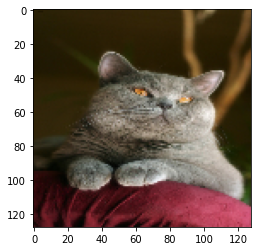

<built-in method reshape of numpy.ndarray object at 0x7f0494765490>


(1, 128, 128, 3)


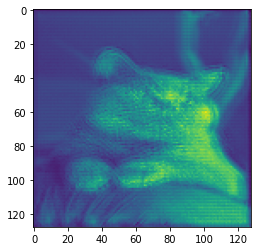

In [91]:
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask

display(sample_image.shape)
print('*'*100)
display(sample_mask.shape)

img = np.array(sample_image)
plt.imshow(img)
plt.show()

img = img.reshape((1,) + img.shape)
print(img.reshape)

pred = model.predict(img)
print(pred.shape)

pred = pred.reshape(pred.shape[1:])
pred = pred[:,:,0]

plt.imshow(pred)
plt.show()

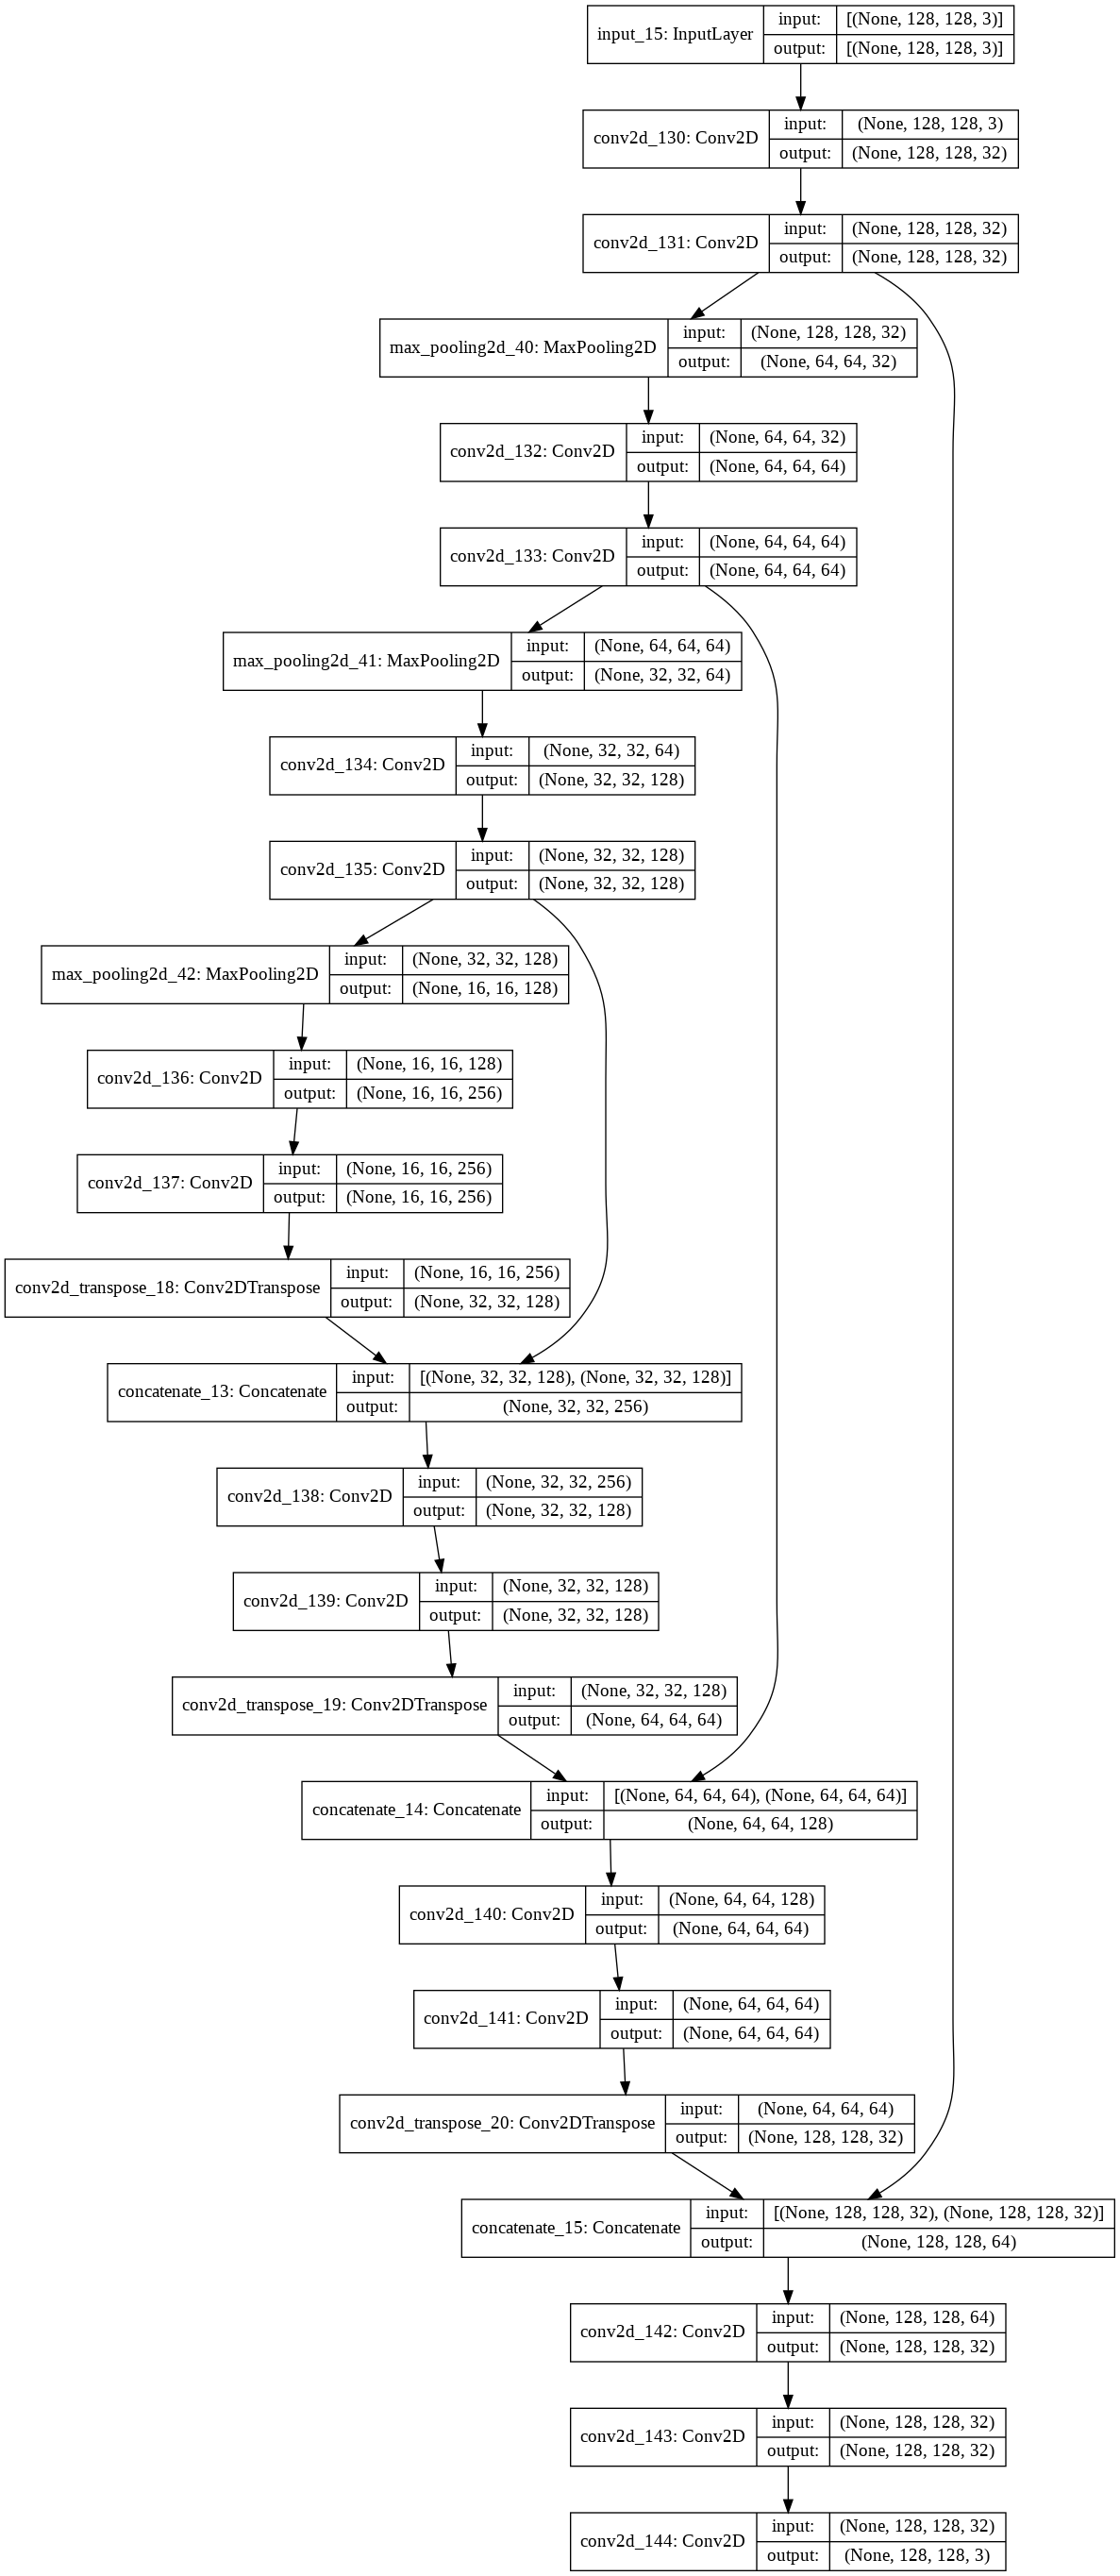

In [92]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [117]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model_history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/15
58/58 [==============================] - 28s 452ms/step - loss: 0.9016 - val_loss: 0.6256
Epoch 2/15
58/58 [==============================] - 25s 436ms/step - loss: 0.6553 - val_loss: 0.6063
Epoch 3/15
58/58 [==============================] - 25s 431ms/step - loss: 0.6034 - val_loss: 0.6185
Epoch 4/15
58/58 [==============================] - 25s 433ms/step - loss: 0.5986 - val_loss: 0.6130
Epoch 5/15
58/58 [==============================] - 25s 433ms/step - loss: 0.5750 - val_loss: 0.5885
Epoch 6/15
58/58 [==============================] - 25s 435ms/step - loss: 0.5660 - val_loss: 0.7456
Epoch 7/15
58/58 [==============================] - 25s 431ms/step - loss: 0.5502 - val_loss: 0.4843
Epoch 8/15
58/58 [==============================] - 25s 433ms/step - loss: 0.5260 - val_loss: 0.4945
Epoch 9/15
58/58 [==============================] - 25s 433ms/step - loss: 0.5051 - val_loss: 0.4788
Epoch 10/15
58/58 [==============================] - 25s 433ms/step - loss: 0.4860 - val_lo

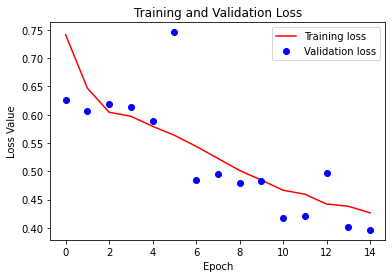

In [119]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


plt.figure()
plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [120]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [121]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [122]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in train_dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

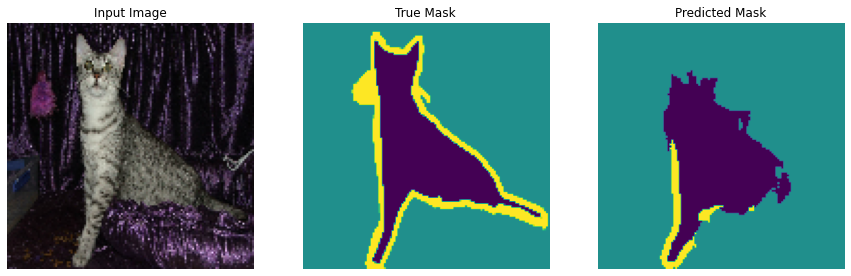

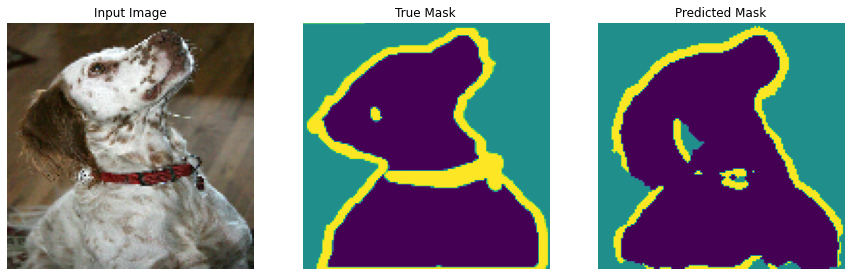

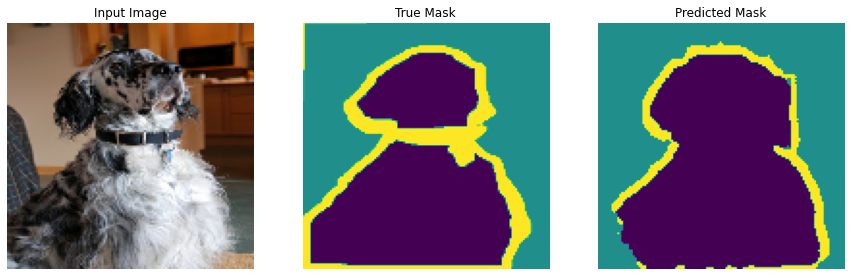

In [123]:
show_predictions(test_dataset, 3)

(128, 128, 3)
****************************************************************************************************
(128, 128, 1)


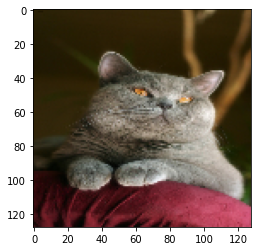

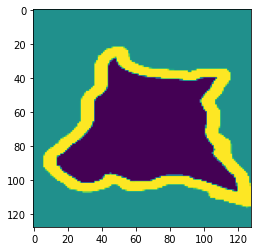

<built-in method reshape of numpy.ndarray object at 0x7f0494667080>
(1, 128, 128, 3)


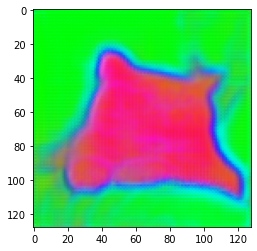

In [127]:
for image, mask in train.take(3):
  sample_image, sample_mask = image, mask

print(sample_image.shape)
print('*'*100)
print(sample_mask.shape)

img = np.array(sample_image)
plt.imshow(img)
plt.show()

mask = np.array(sample_mask)
mask = mask.reshape(mask.shape[0], mask.shape[1])
plt.imshow(mask)
plt.show()

img = img.reshape((1,) + img.shape)
print(img.reshape)

pred = model.predict(img)
print(pred.shape)

pred = pred.reshape(pred.shape[1:])

plt.imshow(pred)
plt.show()

#copied

In [29]:
input_layer = layers.Input(shape = [128,128,3])

conv1 = layers.Conv2D(32, 3, strides=1, padding="same")(input_layer)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)

conv1 = layers.Conv2D(32, 3, strides=1, padding="same")(conv1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation("relu")(conv1)

pool1 = layers.MaxPooling2D(2)(conv1)


model = keras.Model(input_layer, pool1)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0   

In [ ]:
xxxxx

# voc Dataset

In [ ]:
voc, info = tfds.load('voc', with_info=True)

In [ ]:
info

In [ ]:
images = list(voc['train'].map(lambda x: x['image']))
display(len(images))
display(images[0].shape, images[1].shape)

In [ ]:
  image = np.array(images[0])
  plt.imshow(image)

In [ ]:
labels = list(voc['train'].map(lambda x: x['labels']))
display(len(labels))
display(labels[0], labels[1])

In [ ]:
labels_no_difficult = list(voc['train'].map(lambda x: x['labels_no_difficult']))
display(len(labels_no_difficult))
display(labels_no_difficult[0], labels_no_difficult[1])

In [ ]:
objects = list(voc['train'].map(lambda x: x['objects']))
display(len(objects))
display(objects[0])